# Predicciones temporales con modelos de IA

Dentro de este cuaderno de Jupyter se estudiarán distintos modelos de IA para llevar a cabo predicciones sobre series temporales. Los distintos apartados que se presentarán en el cuaderno son:

 1. Carga de librerias, modelos y herramientas a utilizar.
 2. Análisis y preprocesamiento de datos.
 3. Creación y estudio de predicciones con TimeGPT.
 4. Creación y estudio de predicciones con Prophet (NeuroProphet).
 5. Creación y estudio de predicciones con LSMT.
 6. Análisis de resultados y modelo a usar.

## 1. Carga de librerias, modelos y herramientas

In [113]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utilsforecast.preprocessing import fill_gaps
from sklearn.preprocessing import MinMaxScaler

In [114]:
def pretreat_data_df(df, col_name):
    new_df = df[df['interaction'] == col_name].copy()
    new_df.rename(columns={'data.value': col_name}, inplace=True)
    new_df.drop(columns='interaction', inplace=True)
    new_df.set_index('timestamp', inplace=True)
    new_df[col_name] = new_df[col_name].astype(float)
    return new_df

def pretreat_true_false_data_df(df, col_name):
    new_df = df[df['interaction'] == col_name].copy()
    new_df.rename(columns={'data.value': col_name}, inplace=True)
    new_df.drop(columns='interaction', inplace=True)
    new_df.set_index('timestamp', inplace=True)
    new_df[col_name] = new_df[col_name].apply(lambda x: 1 if x == 'true' else 0)
    return new_df

Para este primer acercamiento se tomará como referencia los datos del sensor Suntracer localizado en el Edificio Centro de Investigaciones Tecnológicas de la Información y las Comunicaciones.

In [115]:
# Load the data
data = pd.read_csv('data/wot-data-db.interactions-datas_suntracer.csv')
data['timestamp'] = pd.to_datetime(data['timestamp']).dt.round("min").dt.tz_localize(None)
df_test = data[['timestamp', 'data.value', 'interaction']]

df_temperature = pretreat_data_df(df_test, 'temperature')
df_brightness = pretreat_data_df(df_test, 'brightness')
df_wind = pretreat_data_df(df_test, 'wind')
df_rain = pretreat_true_false_data_df(df_test, 'rain')

df_rain

,rain
timestamp,
2023-03-05 19:15:00,1
2023-03-05 19:29:00,0
2023-03-05 19:37:00,1
2023-03-05 20:11:00,0
2023-03-06 20:22:00,1
...,...
2024-07-11 07:06:00,0
2024-07-11 07:10:00,1
2024-07-11 07:26:00,0


In [116]:
def plot_data(df, col_name):
    plt.figure(figsize=(10,6))
    plt.plot(df)
    plt.title('Suntracer ' + col_name)
    plt.ylabel(col_name)
    plt.show()

def plot_hist(df, col_name):
    plt.figure(figsize=(10,6))
    plt.hist(df)
    plt.title('Suntracer ' + col_name)
    plt.ylabel('Frequency')
    plt.show()

def plot_day_data(df, col_name):
    plt.figure(figsize=(10,6))
    plt.plot(df)
    plt.title('1 day Suntracer ' + col_name)
    plt.ylabel(col_name)
    plt.show()

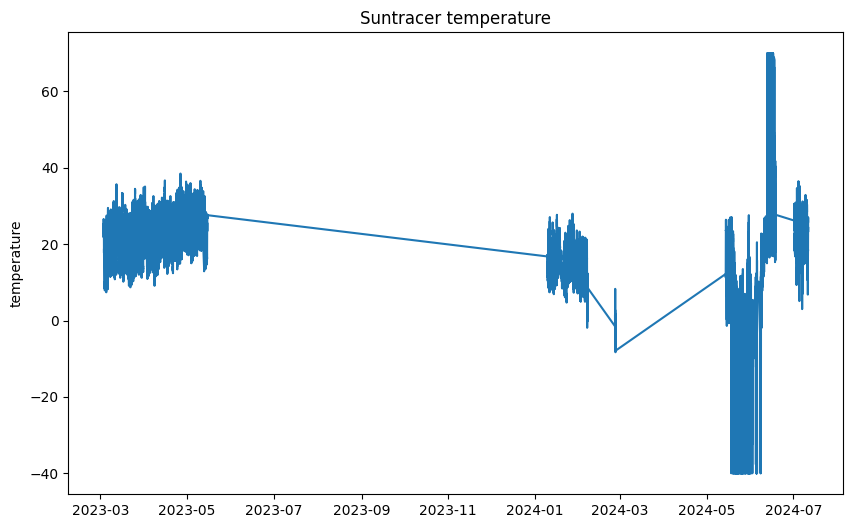

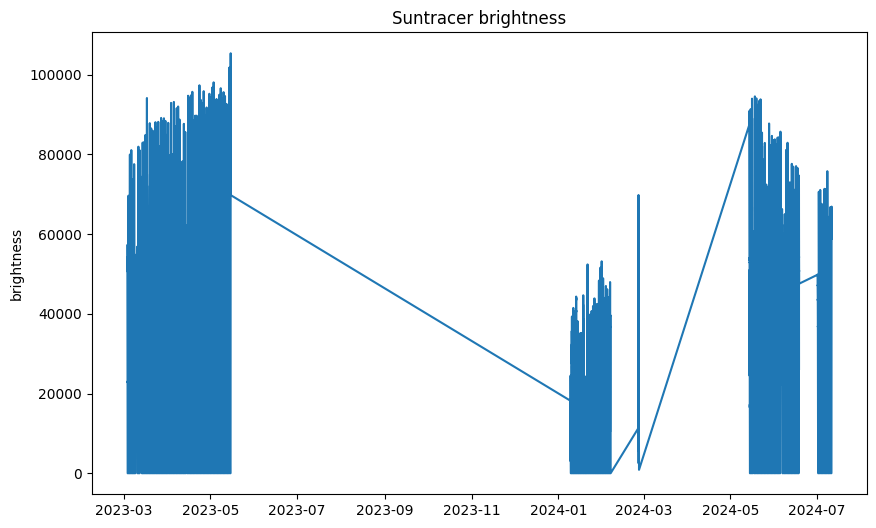

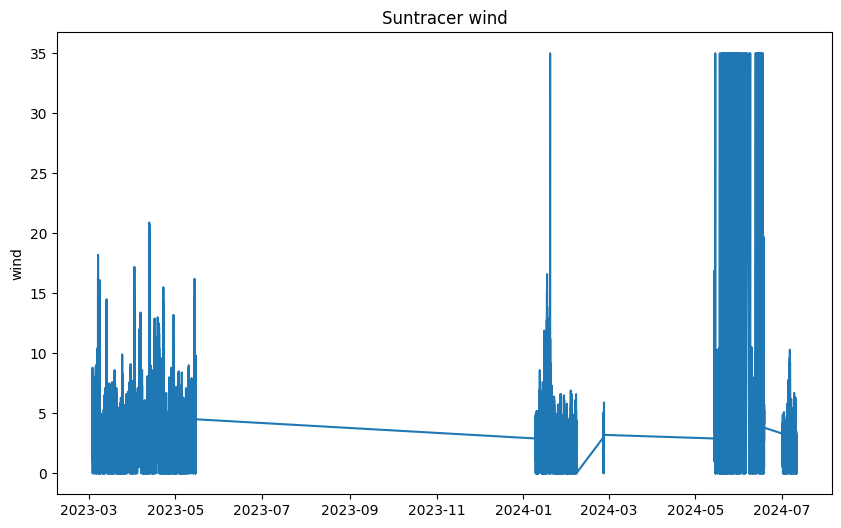

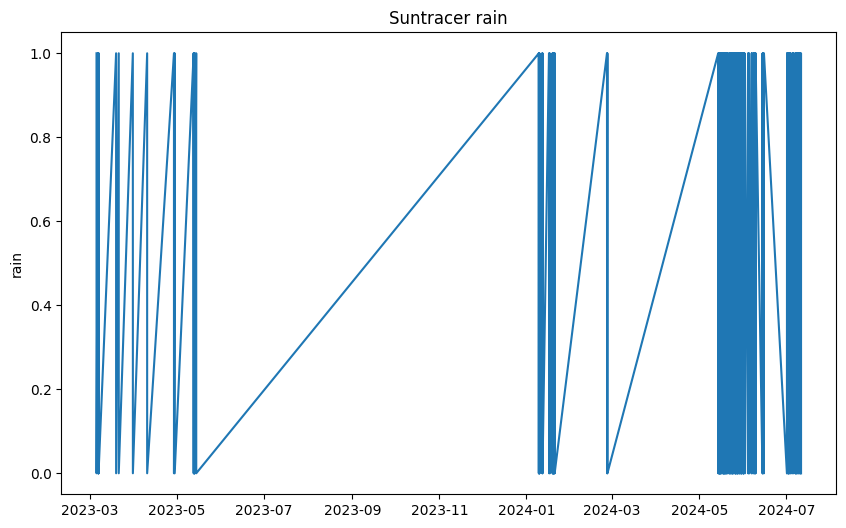

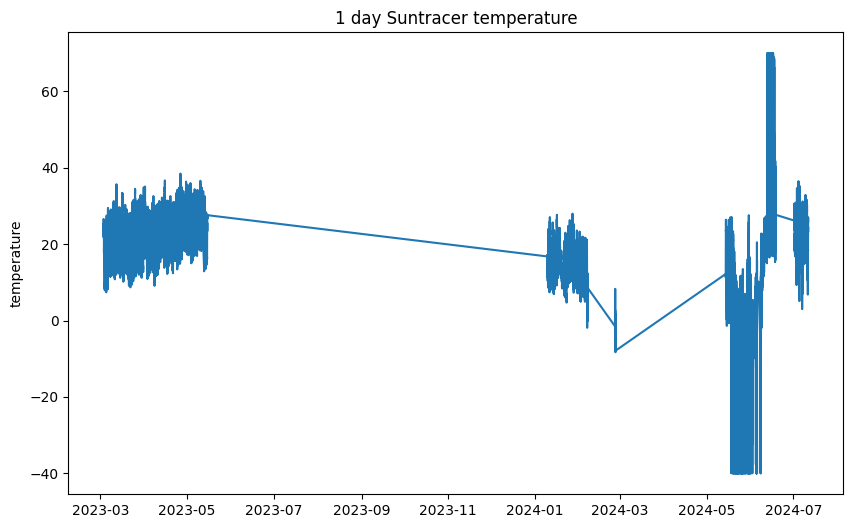

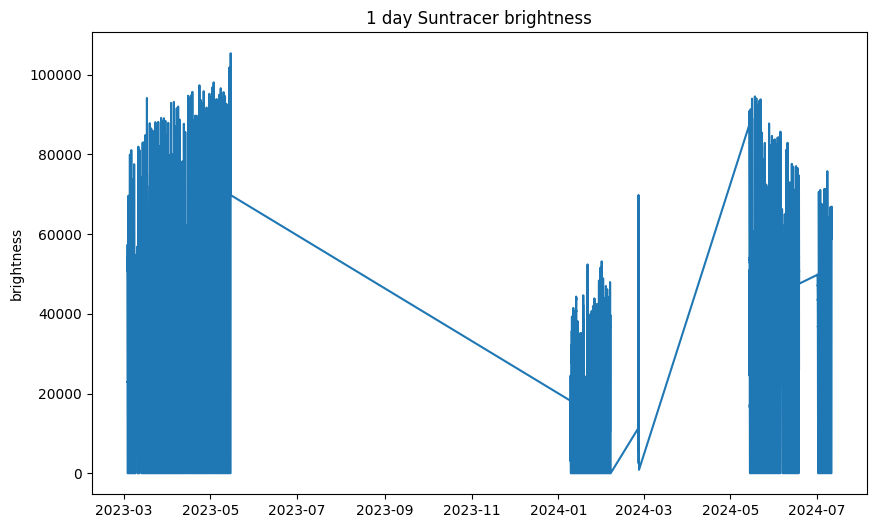

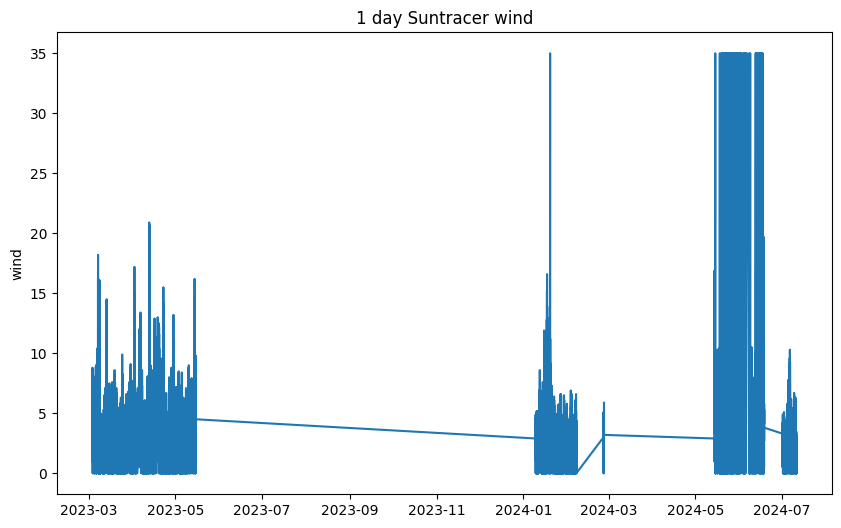

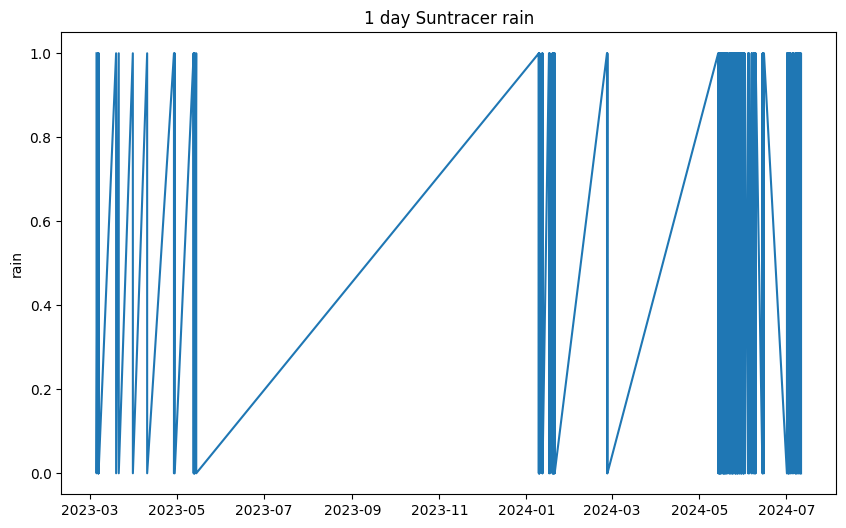

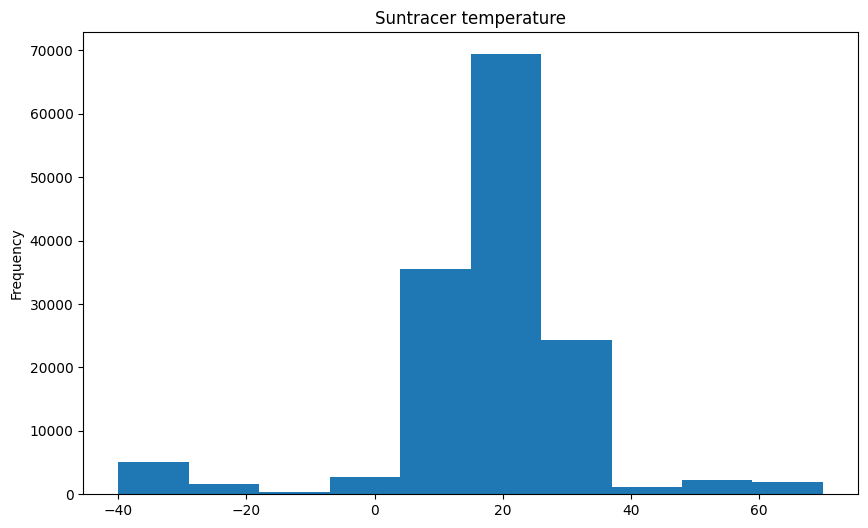

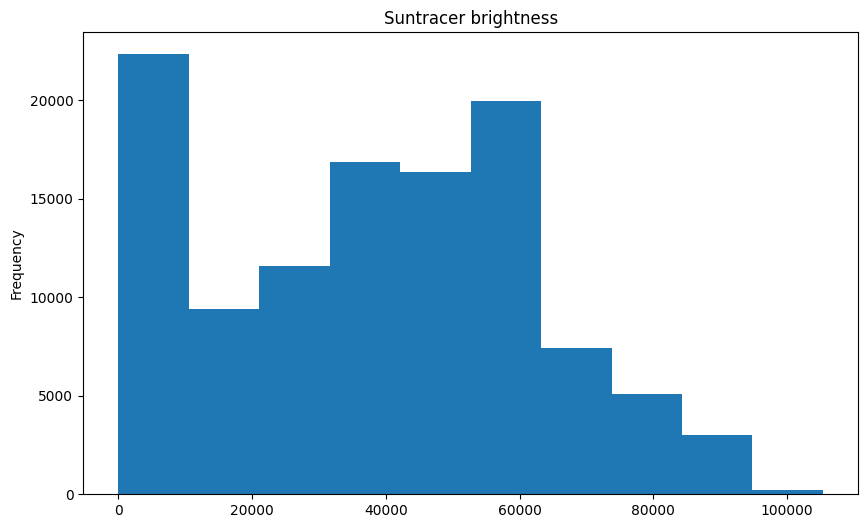

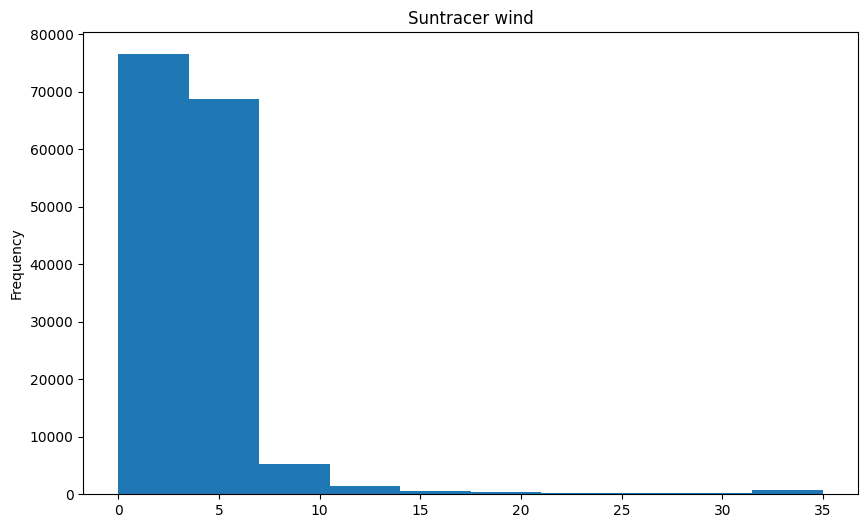

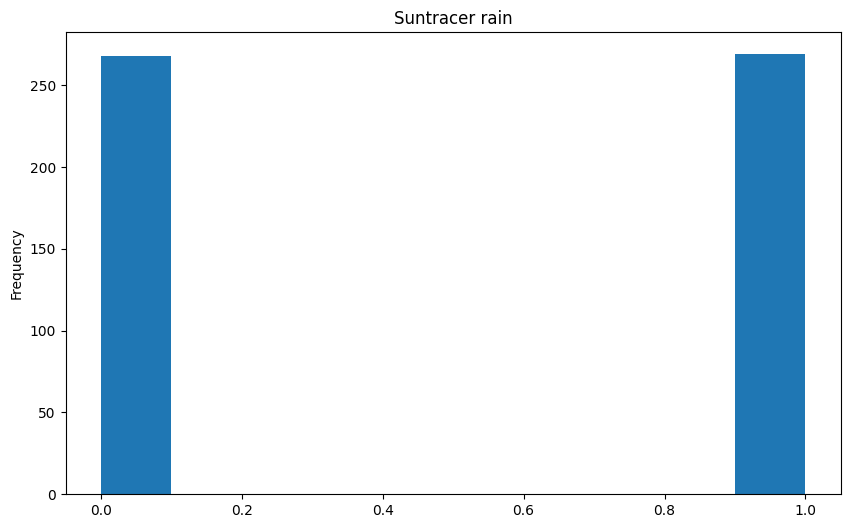

In [117]:
plot_data(df_temperature, 'temperature')
plot_data(df_brightness, 'brightness')
plot_data(df_wind, 'wind')
plot_data(df_rain, 'rain')
plot_day_data(df_temperature, 'temperature')
plot_day_data(df_brightness, 'brightness')
plot_day_data(df_wind, 'wind')
plot_day_data(df_rain, 'rain')
plot_hist(df_temperature, 'temperature')
plot_hist(df_brightness, 'brightness')
plot_hist(df_wind, 'wind')
plot_hist(df_rain, 'rain')

Debido a todos estos problemas, se ha optado por tomar únicamente el tramo entre marzo y mayo de 2023.

In [118]:
def reduce_df(df, start_date, end_date):
    return df[(df.index >= start_date) & (df.index <= end_date)]

In [119]:
reduced_df_temperature = reduce_df(df_temperature, '2023-03-01', '2023-05-15')
reduced_df_brightness = reduce_df(df_brightness, '2023-03-01', '2023-05-15')
reduced_df_wind = reduce_df(df_wind, '2023-03-01', '2023-05-15')
reduced_df_rain = reduce_df(df_rain, '2023-03-01', '2023-05-15')

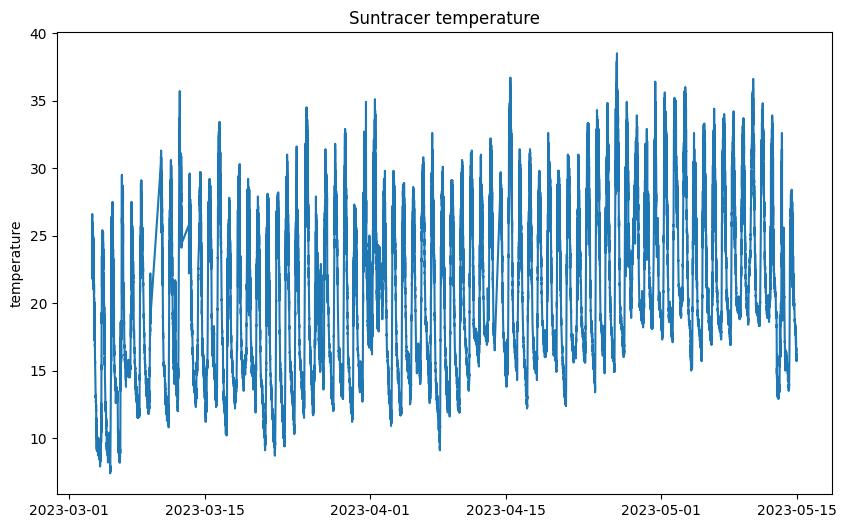

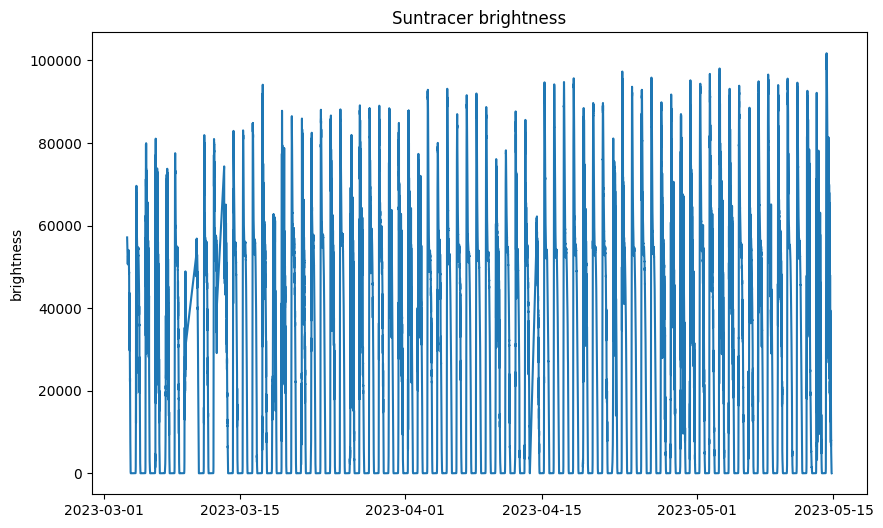

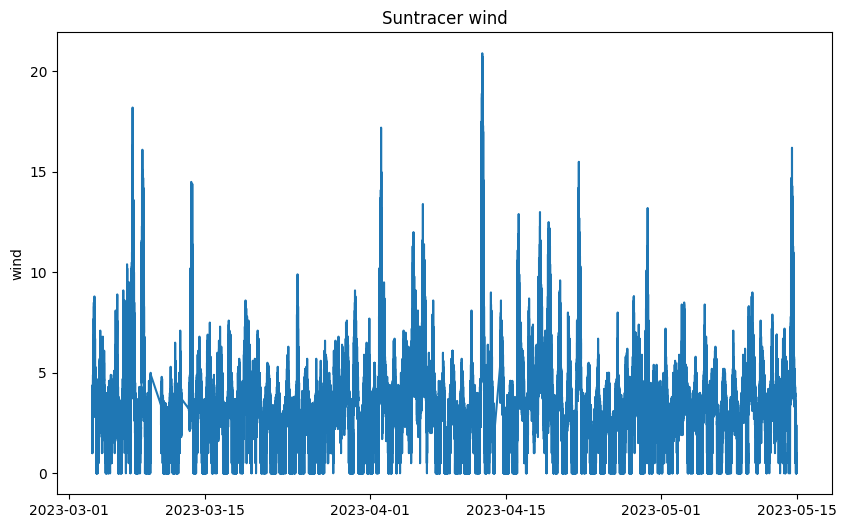

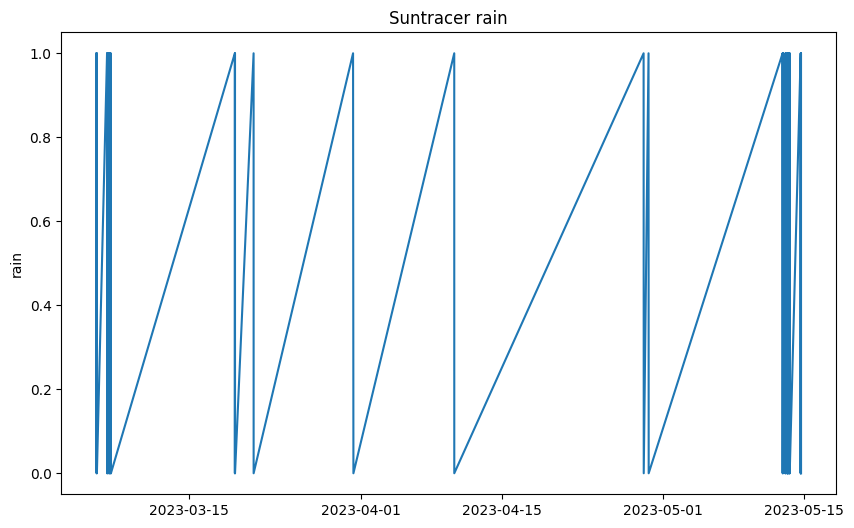

In [120]:
plot_data(reduced_df_temperature, 'temperature')
plot_data(reduced_df_brightness, 'brightness')
plot_data(reduced_df_wind, 'wind')
plot_data(reduced_df_rain, 'rain')

Registros duplicados

In [121]:
def delete_duplicates(df, col_name):
    print(col_name + ' - Número de registros duplicados:', df.index.duplicated().sum())
    if df.index.duplicated().sum() > 0:
        df = df.groupby(df.index).mean()
        print(col_name + ' - Número de registros tras eliminar duplicados:' + str(len(df)))
    else:
        print('No hay registros duplicados')
    return df
    

In [122]:
reduced_df_temperature = delete_duplicates(reduced_df_temperature, 'temperature')
reduced_df_brightness = delete_duplicates(reduced_df_brightness, 'brightness')
reduced_df_wind = delete_duplicates(reduced_df_wind, 'wind')
reduced_df_rain = delete_duplicates(reduced_df_rain, 'rain')

temperature - Número de registros duplicados: 491
temperature - Número de registros tras eliminar duplicados:71746
brightness - Número de registros duplicados: 479
brightness - Número de registros tras eliminar duplicados:54920
wind - Número de registros duplicados: 730
wind - Número de registros tras eliminar duplicados:84820
rain - Número de registros duplicados: 0
No hay registros duplicados


In [123]:
def fill_gaps_df(df,col_name, boolean=False):
    print(col_name + " - Original data: ", len(df), "rows")
    
    # Rellenamos los valores faltantes
    df = df.resample('min').asfreq()
    if boolean:
        df[col_name] = df[col_name].interpolate(method='ffill')
    else:
        df[col_name] = df[col_name].interpolate(method='linear', limit_direction='both')
    
    print(col_name + " - Updated data: ", len(df), "rows")
    
    return df

In [124]:
reduced_df_temperature = fill_gaps_df(reduced_df_temperature, 'temperature')
reduced_df_brightness = fill_gaps_df(reduced_df_brightness, 'brightness')
reduced_df_wind = fill_gaps_df(reduced_df_wind, 'wind')
reduced_df_rain = fill_gaps_df(reduced_df_rain, 'rain', boolean=True)

temperature - Original data:  71746 rows
temperature - Updated data:  104551 rows
brightness - Original data:  54920 rows
brightness - Updated data:  104283 rows
wind - Original data:  84820 rows
wind - Updated data:  104551 rows
rain - Original data:  64 rows
rain - Updated data:  100621 rows


C:\Users\Ivan\AppData\Local\Temp\ipykernel_8460\3993579754.py:7: FutureWarning: Series.interpolate with method=ffill is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col_name] = df[col_name].interpolate(method='ffill')


In [125]:
reduced_df_temperature

,temperature
timestamp,
2023-03-03 09:30:00,22.70
2023-03-03 09:31:00,22.20
2023-03-03 09:32:00,21.80
2023-03-03 09:33:00,22.10
2023-03-03 09:34:00,22.60
...,...
2023-05-14 23:56:00,16.00
2023-05-14 23:57:00,16.05
2023-05-14 23:58:00,16.10


In [126]:
reduced_df_rain

,rain
timestamp,
2023-03-05 19:15:00,1.0
2023-03-05 19:16:00,1.0
2023-03-05 19:17:00,1.0
2023-03-05 19:18:00,1.0
2023-03-05 19:19:00,1.0
...,...
2023-05-14 16:11:00,1.0
2023-05-14 16:12:00,1.0
2023-05-14 16:13:00,1.0


In [127]:
reduced_df_brightness

,brightness
timestamp,
2023-03-03 09:30:00,57139.200000
2023-03-03 09:31:00,57057.280000
2023-03-03 09:32:00,56934.400000
2023-03-03 09:33:00,56729.600000
2023-03-03 09:34:00,56606.720000
...,...
2023-05-14 19:28:00,8.000000
2023-05-14 19:29:00,5.000000
2023-05-14 19:30:00,3.333333


In [128]:
reduced_df_rain

,rain
timestamp,
2023-03-05 19:15:00,1.0
2023-03-05 19:16:00,1.0
2023-03-05 19:17:00,1.0
2023-03-05 19:18:00,1.0
2023-03-05 19:19:00,1.0
...,...
2023-05-14 16:11:00,1.0
2023-05-14 16:12:00,1.0
2023-05-14 16:13:00,1.0


Definimos datos de inicio y fin ignorando primer y último dia

In [129]:
reduced_df_temperature = reduced_df_temperature[(reduced_df_temperature.index >= '2023-03-06') & (reduced_df_temperature.index <= '2023-05-14')]
reduced_df_brightness = reduced_df_brightness[(reduced_df_brightness.index >= '2023-03-06') & (reduced_df_brightness.index <= '2023-05-14')]
reduced_df_wind = reduced_df_wind[(reduced_df_wind.index >= '2023-03-06') & (reduced_df_wind.index <= '2023-05-14')]
reduced_df_rain = reduced_df_rain[(reduced_df_rain.index >= '2023-03-06') & (reduced_df_rain.index <= '2023-05-14')]
len(reduced_df_temperature), len(reduced_df_brightness), len(reduced_df_wind), len(reduced_df_rain)

(99361, 99361, 99361, 99361)

Normalizamos los datos

In [130]:
def normalize_df(df):
    scaler = MinMaxScaler()
    df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
    return df_normalized, scaler

In [131]:
reduced_df_temperature, scaler_temperature = normalize_df(reduced_df_temperature)
reduced_df_brightness, scaler_brightness = normalize_df(reduced_df_brightness)
reduced_df_wind, scaler_wind = normalize_df(reduced_df_wind)

Por último, combinamos todos los datos en una misma tabla

In [132]:
# Merge all df into one
completed_df = pd.concat([reduced_df_temperature, reduced_df_brightness, reduced_df_wind, reduced_df_rain], axis=1)
completed_df

,temperature,brightness,wind,rain
timestamp,,,,
2023-03-06 00:00:00,0.151815,0.000024,0.186603,0.0
2023-03-06 00:01:00,0.158416,0.000024,0.220096,0.0
2023-03-06 00:02:00,0.160066,0.000024,0.181818,0.0
2023-03-06 00:03:00,0.161716,0.000024,0.220096,0.0
2023-03-06 00:04:00,0.158416,0.000025,0.229665,0.0
...,...,...,...,...
2023-05-13 23:56:00,0.231023,0.000025,0.162679,0.0
2023-05-13 23:57:00,0.237624,0.000025,0.153110,0.0
2023-05-13 23:58:00,0.238724,0.000025,0.191388,0.0


## Normalización de los valores + añadir periodicidad

In [133]:
day = 60*60*24
year = 365.2425*day

completed_df['seconds'] = completed_df.index.map(pd.Timestamp.timestamp)

# A partir del seno y coseno podemos trabajar también la periodicidad de los datos. Concretamente, la de los dias y el año.

completed_df['day_sin'] = np.sin(completed_df['seconds'] * (2 * np.pi / year))
completed_df['day_cos'] = np.cos(completed_df['seconds'] * (2 * np.pi / year))
completed_df['year_sin'] = np.sin(completed_df['seconds'] * (2 * np.pi / year))
completed_df['year_cos'] = np.cos(completed_df['seconds'] * (2 * np.pi / year))

completed_df.drop(columns=['seconds'], inplace=True)

completed_df

,temperature,brightness,wind,rain,day_sin,day_cos,year_sin,year_cos
timestamp,,,,,,,,
2023-03-06 00:00:00,0.151815,0.000024,0.186603,0.0,0.892796,0.450461,0.892796,0.450461
2023-03-06 00:01:00,0.158416,0.000024,0.220096,0.0,0.892802,0.450450,0.892802,0.450450
2023-03-06 00:02:00,0.160066,0.000024,0.181818,0.0,0.892807,0.450439,0.892807,0.450439
2023-03-06 00:03:00,0.161716,0.000024,0.220096,0.0,0.892812,0.450429,0.892812,0.450429
2023-03-06 00:04:00,0.158416,0.000025,0.229665,0.0,0.892818,0.450418,0.892818,0.450418
...,...,...,...,...,...,...,...,...
2023-05-13 23:56:00,0.231023,0.000025,0.162679,0.0,0.752028,-0.659131,0.752028,-0.659131
2023-05-13 23:57:00,0.237624,0.000025,0.153110,0.0,0.752020,-0.659140,0.752020,-0.659140
2023-05-13 23:58:00,0.238724,0.000025,0.191388,0.0,0.752012,-0.659149,0.752012,-0.659149


## 5. Creación y estudio de predicciones con LSMT.

Las redes Long Shot Memory Term son las redes neuronales indicadas para llevar a cabo la predicción de valores futuros dentro de series temporales. Dentro de este cuaderno analizaremos los resultados a partir de una implementación manual y con el uso de métodos ya definidos por Tensorflow/PyTorch 

In [134]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError, RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError as mse_tf, MeanAbsoluteError as mae_tf

Antes de comenzar a definir el modelo será necesario detallar el número de datos necesarios para la entrada y la salida. En este caso, se ha optado por predecir hasta 15 minutos en el futuro a partir de los datos de los 60 minutos anteriores. Esta funcionalidad se cumple con el método split_sequences(). Las entradas (input) se localizarán en X, mientras que y será el resultado que dan. 

In [135]:
def split_sequence(df, window_size = 60, target_size = 15):
    X, y = [], []
    for i in range(len(df)-window_size-target_size):
        X.append(df.iloc[i:(i+window_size)].values)
        row = df.iloc[(i+window_size)].values
        y.append(row[:-4])
    return np.array(X), np.array(y)

In [136]:
WINDOW_SIZE = 60
TARGET_SIZE = 15
X, y = split_sequence(completed_df, WINDOW_SIZE, TARGET_SIZE)
X.shape, y.shape

((99286, 60, 8), (99286, 4))

In [137]:
X

array([[[ 1.51815182e-01,  2.42707140e-05,  1.86602871e-01, ...,
          4.50460605e-01,  8.92796306e-01,  4.50460605e-01],
        [ 1.58415842e-01,  2.43427340e-05,  2.20095694e-01, ...,
          4.50449939e-01,  8.92801687e-01,  4.50449939e-01],
        [ 1.60066007e-01,  2.44147539e-05,  1.81818182e-01, ...,
          4.50439273e-01,  8.92807068e-01,  4.50439273e-01],
        ...,
        [ 1.15511551e-01,  2.83758497e-05,  1.84210526e-01, ...,
          4.49852556e-01,  8.93102837e-01,  4.49852556e-01],
        [ 1.13861386e-01,  2.84478696e-05,  2.05741627e-01, ...,
          4.49841887e-01,  8.93108211e-01,  4.49841887e-01],
        [ 1.12211221e-01,  2.85198895e-05,  1.81818182e-01, ...,
          4.49831218e-01,  8.93113585e-01,  4.49831218e-01]],

       [[ 1.58415842e-01,  2.43427340e-05,  2.20095694e-01, ...,
          4.50449939e-01,  8.92801687e-01,  4.50449939e-01],
        [ 1.60066007e-01,  2.44147539e-05,  1.81818182e-01, ...,
          4.50439273e-01,  8.92807068e

In [138]:
y

array([[1.05610561e-01, 2.85919094e-05, 8.13397129e-02, 0.00000000e+00],
       [1.04510451e-01, 2.86639293e-05, 1.38755981e-01, 0.00000000e+00],
       [1.03410341e-01, 2.87359493e-05, 1.91387560e-01, 0.00000000e+00],
       ...,
       [2.47524752e-01, 2.35770763e-05, 1.86602871e-01, 0.00000000e+00],
       [2.46699670e-01, 2.36706361e-05, 2.00956938e-01, 0.00000000e+00],
       [2.45874587e-01, 2.37641959e-05, 1.91387560e-01, 0.00000000e+00]])

In [139]:
lsmt_separation_rows = int(len(X)*0.8)
X_train, X_test = X[:lsmt_separation_rows], X[lsmt_separation_rows:]
y_train, y_test = y[:lsmt_separation_rows], y[lsmt_separation_rows:]

len(X_train), len(X_test), len(y_train), len(y_test)

(79428, 19858, 79428, 19858)

In [140]:
HandMadeLSTM = Sequential()
HandMadeLSTM.add(InputLayer((WINDOW_SIZE, len(completed_df.columns))))
HandMadeLSTM.add(LSTM(64, activation='relu'))
HandMadeLSTM.add(Dense(len(completed_df.columns)-4))

HandMadeLSTM.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 64)             │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,948 (74.02 KB)

 Trainable params: 18,948 (74.02 KB)

 Non-trainable params: 0 (0.00 B)

In [141]:
modelPath = 'LSMTTensorflow/bestModelMultiParameter.keras'
checkpoints = ModelCheckpoint(modelPath, save_best_only=True)
HandMadeLSTM.compile(optimizer=Adam(learning_rate=0.001), loss=mse_tf(), metrics=[mae_tf(), RootMeanSquaredError()])

In [142]:
HandMadeLSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[checkpoints])

Epoch 1/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 44s 21ms/step - loss: 0.0040 - mean_absolute_error: 0.0285 - root_mean_squared_error: 0.0559 - val_loss: 0.0010 - val_mean_absolute_error: 0.0192 - val_root_mean_squared_error: 0.0322
Epoch 2/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 37s 19ms/step - loss: 7.0589e-04 - mean_absolute_error: 0.0134 - root_mean_squared_error: 0.0266 - val_loss: 8.0345e-04 - val_mean_absolute_error: 0.0152 - val_root_mean_squared_error: 0.0283
Epoch 3/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 37s 18ms/step - loss: 6.3907e-04 - mean_absolute_error: 0.0127 - root_mean_squared_error: 0.0253 - val_loss: 8.0266e-04 - val_mean_absolute_error: 0.0153 - val_root_mean_squared_error: 0.0283
Epoch 4/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 38s 19ms/step - loss: 6.1518e-04 - mean_absolute_error: 0.0120 - root_mean_squared_error: 0.0248 - val_loss: 7.0282e-04 - val_mean_absolute_error: 0.0132 - val_root_mean_squared_error: 0.0265
Epoch 5/20
1986/1986 ━━━━━━━━━━━━━━━━━━━━ 38s 19ms/step - loss: 5.9080e-

In [143]:
HandMadeLSTM = load_model(modelPath)

array([[1.05610561e-01, 2.85919094e-05, 8.13397129e-02, 0.00000000e+00],
       [1.04510451e-01, 2.86639293e-05, 1.38755981e-01, 0.00000000e+00],
       [1.03410341e-01, 2.87359493e-05, 1.91387560e-01, 0.00000000e+00],
       ...,
       [3.91089109e-01, 5.02819096e-05, 1.69856459e-01, 0.00000000e+00],
       [3.92739274e-01, 5.03704341e-05, 1.77033493e-01, 0.00000000e+00],
       [3.93839384e-01, 5.04589585e-05, 1.86602871e-01, 0.00000000e+00]])

In [149]:
test_predictions = HandMadeLSTM.predict(X_test)
test_predictions.shape

621/621 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step


(19858, 4)

In [150]:
test_predictions

array([[ 0.39261764,  0.00449814,  0.17428677, -0.00155312],
       [ 0.39362997,  0.00440563,  0.17243405, -0.002526  ],
       [ 0.39484984,  0.00453879,  0.17610238, -0.00168007],
       ...,
       [ 0.24750498,  0.00462125,  0.17595494, -0.00490025],
       [ 0.24644953,  0.00427568,  0.17725047, -0.00450495],
       [ 0.24568963,  0.00284813,  0.1824207 , -0.00323754]],
      dtype=float32)

In [163]:
#Take first column of the prediction
test_predictions_temperature = test_predictions[:,0]
test_predictions_brightness = test_predictions[:,1]
test_predictions_wind = test_predictions[:,2]
test_predictions_rain = test_predictions[:,3]

array([0.00449814, 0.00440563, 0.00453879, ..., 0.00462125, 0.00427568,
       0.00284813], dtype=float32)

In [159]:
test_predictions

array([[ 0.39261764,  0.00449814,  0.17428677, -0.00155312],
       [ 0.39362997,  0.00440563,  0.17243405, -0.002526  ],
       [ 0.39484984,  0.00453879,  0.17610238, -0.00168007],
       ...,
       [ 0.24750498,  0.00462125,  0.17595494, -0.00490025],
       [ 0.24644953,  0.00427568,  0.17725047, -0.00450495],
       [ 0.24568963,  0.00284813,  0.1824207 , -0.00323754]],
      dtype=float32)

In [171]:
def plot_predictions(y_test, predictions):
    plt.figure(figsize=(10,6))
    plt.plot(y_test[:,0], label='True 1')
    plt.plot(y_test[:,1], label='True 2')
    plt.plot(y_test[:,2], label='True 3')
    plt.plot(y_test[:,3], label='True 4')
    plt.plot(predictions[:,0], label='Predicted 1')
    plt.plot(predictions[:,1], label='Predicted 2')
    plt.plot(predictions[:,2], label='Predicted 3')
    plt.plot(predictions[:,3], label='Predicted 4')
    plt.legend()
    plt.show()

def plot_single_prediction(y_test, predictions, index, title):
    plt.figure(figsize=(10,6))
    plt.plot(y_test[:,index], label='True')
    plt.plot(predictions[:,index], label='Predicted')
    plt.title(title)
    plt.legend()
    plt.show()

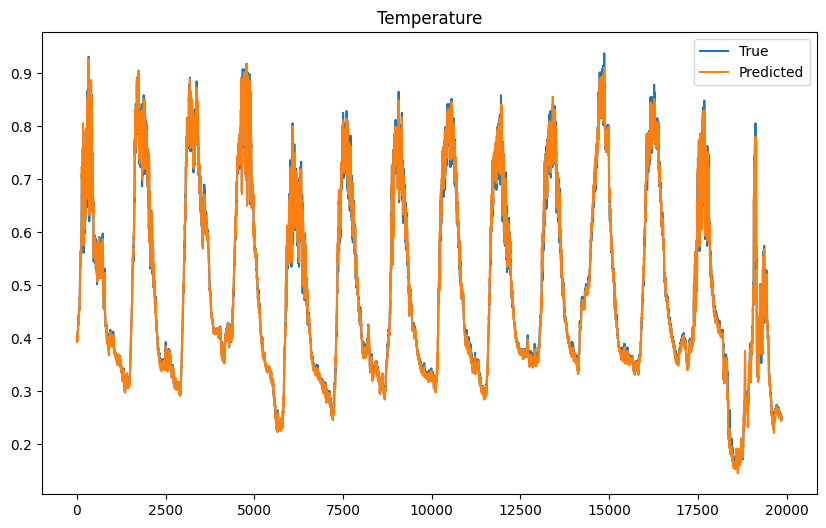

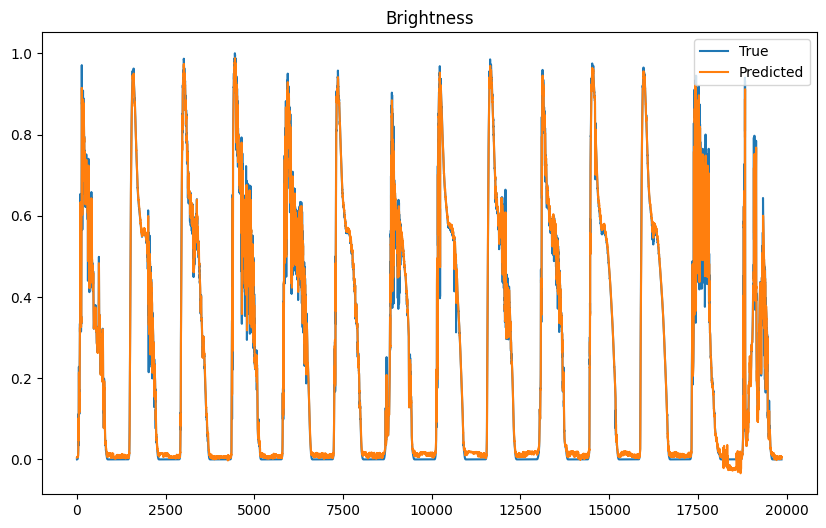

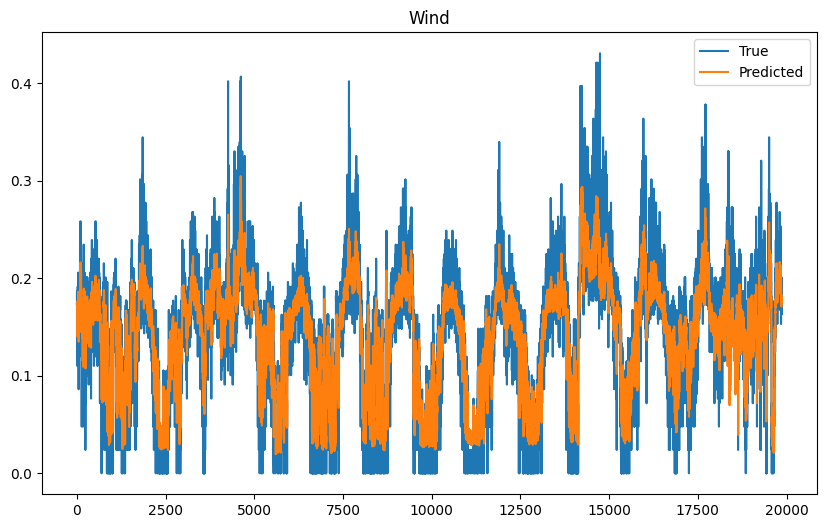

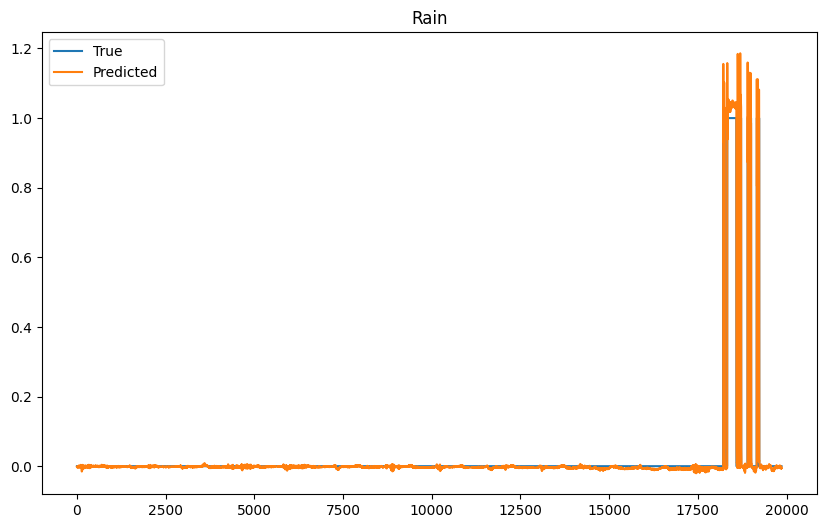

In [172]:
plot_single_prediction(y_test, test_predictions, 0, 'Temperature')
plot_single_prediction(y_test, test_predictions, 1, 'Brightness')
plot_single_prediction(y_test, test_predictions, 2, 'Wind')
plot_single_prediction(y_test, test_predictions, 3, 'Rain')

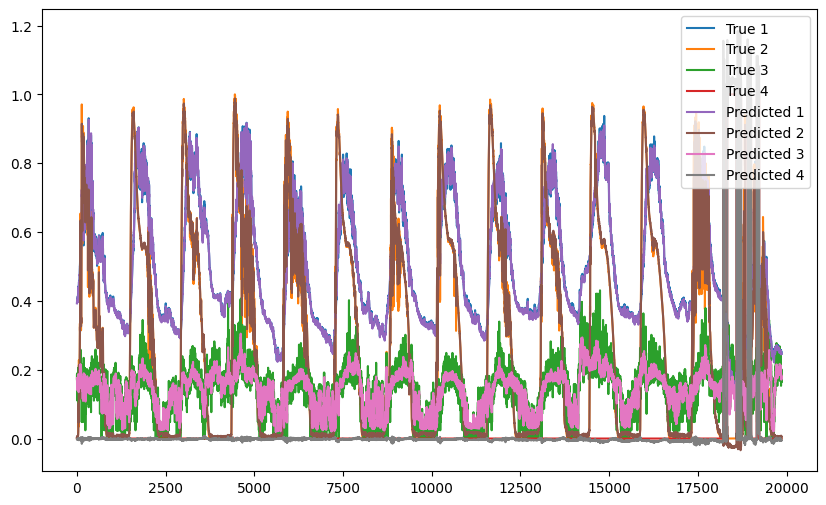

In [165]:
plot_predictions(y_test, test_predictions)

In [ ]:
# Evaluate the predictions
from sklearn.metrics import mean_squared_error, mean_absolute_error

print('Train MSE:', mean_squared_error(y_train.flatten(), train_predictions))
print('Train MAE:', mean_absolute_error(y_train.flatten(), train_predictions))
print('Test MSE:', mean_squared_error(y_test.flatten(), test_predictions))
print('Test MAE:', mean_absolute_error(y_test.flatten(), test_predictions))

Train MSE: 0.6041863741250426
Train MAE: 0.4855493285446168
Test MSE: 0.6730638186211149
Test MAE: 0.5036946791289229


In [ ]:
train_results_LSTM['unique_id'] = 'suntracer_temperature_LSMT'
test_results_LSTM['unique_id'] = 'suntracer_temperature_LSMT'
evaluate(train_results_LSTM, target_col='Predictions', metrics=[mae, mse, rmse])

,unique_id,metric,Actuals
0,suntracer_temperature_LSMT,mae,0.485549
1,suntracer_temperature_LSMT,mse,0.604186
2,suntracer_temperature_LSMT,rmse,0.777294


In [ ]:
evaluate(test_results_LSTM, target_col='Predictions', metrics=[mae, mse, rmse])

,unique_id,metric,Actuals
0,suntracer_temperature_LSMT,mae,0.503695
1,suntracer_temperature_LSMT,mse,0.673064
2,suntracer_temperature_LSMT,rmse,0.820405


### Multistep / Predecir valores dentro de 60 minutos

Evaluamos para 60 minutos, 360 minutos y 720 minutos

In [ ]:
horizons = [60, 360, 720]

WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




Epoch 1/20
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 3s 944us/step - loss: 66.1093 - mean_absolute_error: 4.4968 - root_mean_squared_error: 7.2260 - val_loss: 2.2402 - val_mean_absolute_error: 1.0155 - val_root_mean_squared_error: 1.4967
Epoch 2/20
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 2s 938us/step - loss: 2.1244 - mean_absolute_error: 0.9570 - root_mean_squared_error: 1.4574 - val_loss: 2.2372 - val_mean_absolute_error: 1.0223 - val_root_mean_squared_error: 1.4957
Epoch 3/20
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 2s 999us/step - loss: 2.1232 - mean_absolute_error: 0.9612 - root_mean_squared_error: 1.4571 - val_loss: 2.2533 - val_mean_absolute_error: 0.9842 - val_root_mean_squared_error: 1.5011
Epoch 4/20
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 2s 916us/step - loss: 2.1221 - mean_absolute_error: 0.9585 - root_mean_squared_error: 1.4567 - val_loss: 2.2761 - val_mean_absolute_error: 0.9891 - val_root_mean_squared_error: 1.5087
Epoch 5/20
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 2s 842us/step - loss: 2.1060 - mean_absolute_error: 0

WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




Epoch 1/20
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 83.9121 - mean_absolute_error: 6.1750 - root_mean_squared_error: 8.5571 - val_loss: 19.1015 - val_mean_absolute_error: 3.1033 - val_root_mean_squared_error: 4.3705
Epoch 2/20
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 2s 969us/step - loss: 18.3914 - mean_absolute_error: 3.3197 - root_mean_squared_error: 4.2885 - val_loss: 19.2370 - val_mean_absolute_error: 3.0563 - val_root_mean_squared_error: 4.3860
Epoch 3/20
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 2s 924us/step - loss: 18.3118 - mean_absolute_error: 3.3136 - root_mean_squared_error: 4.2792 - val_loss: 21.7932 - val_mean_absolute_error: 3.0721 - val_root_mean_squared_error: 4.6683
Epoch 4/20
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 2s 883us/step - loss: 18.2485 - mean_absolute_error: 3.2941 - root_mean_squared_error: 4.2718 - val_loss: 19.5180 - val_mean_absolute_error: 3.0675 - val_root_mean_squared_error: 4.4179
Epoch 5/20
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 2s 894us/step - loss: 18.3092 - mean_absolute_er

WARNING - (py.warnings._showwarnmsg) - c:\Users\IvO\Desktop\testGit\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.




Epoch 1/20
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 104.0498 - mean_absolute_error: 7.5920 - root_mean_squared_error: 9.7503 - val_loss: 27.4620 - val_mean_absolute_error: 3.8967 - val_root_mean_squared_error: 5.2404
Epoch 2/20
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 23.9124 - mean_absolute_error: 3.8967 - root_mean_squared_error: 4.8900 - val_loss: 29.7242 - val_mean_absolute_error: 3.9851 - val_root_mean_squared_error: 5.4520
Epoch 3/20
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 23.8151 - mean_absolute_error: 3.8656 - root_mean_squared_error: 4.8801 - val_loss: 31.0381 - val_mean_absolute_error: 4.0511 - val_root_mean_squared_error: 5.5712
Epoch 4/20
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 23.6223 - mean_absolute_error: 3.8505 - root_mean_squared_error: 4.8602 - val_loss: 28.1332 - val_mean_absolute_error: 3.9215 - val_root_mean_squared_error: 5.3041
Epoch 5/20
2090/2090 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 23.6900 - mean_absolute_error: 3.

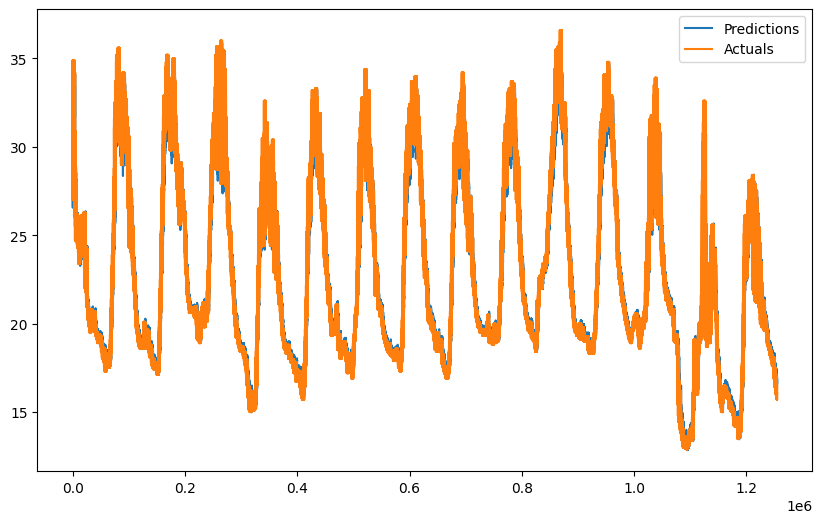

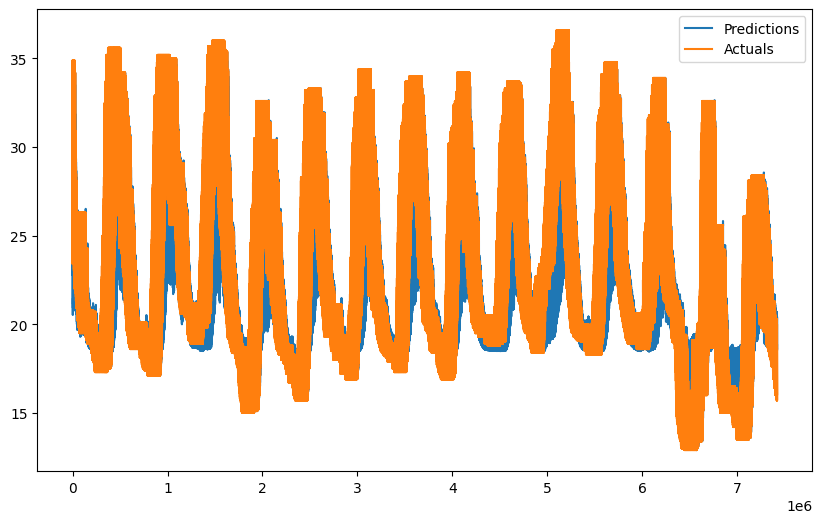

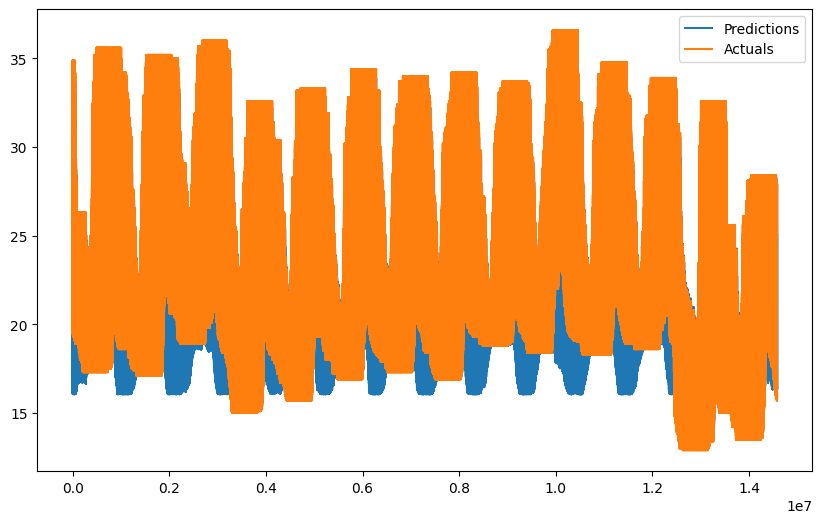

In [ ]:
for horizon in horizons:
    X, y = split_sequence(completed_df['y'], 1, horizon)
    X_train, X_test = X[:lsmt_separation_rows], X[lsmt_separation_rows:]
    y_train, y_test = y[:lsmt_separation_rows], y[lsmt_separation_rows:]

    HandMadeLSTM = Sequential()
    HandMadeLSTM.add(LSTM(64, activation='relu', input_shape=(1, 1)))
    HandMadeLSTM.add(Dense(horizon))

    modelPath = f'LSMTTensorflow/bestModel_{horizon}.keras'
    checkpoints = ModelCheckpoint(modelPath, save_best_only=True)
    HandMadeLSTM.compile(optimizer=Adam(learning_rate=0.001), loss=mse_tf(), metrics=[mae_tf(), RootMeanSquaredError()])

    HandMadeLSTM.fit(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[checkpoints])

    HandMadeLSTM = load_model(modelPath)

    train_predictions = HandMadeLSTM.predict(X_train).flatten()
    train_results = pd.DataFrame(data={'Predictions': train_predictions, 'Actuals': y_train.flatten()})
    print(f'Train results for horizon {horizon}')
    print('Train MSE:', mean_squared_error(y_train.flatten(), train_predictions))
    print('Train MAE:', mean_absolute_error(y_train.flatten(), train_predictions))

    test_predictions = HandMadeLSTM.predict(X_test).flatten()
    test_results = pd.DataFrame(data={'Predictions': test_predictions, 'Actuals': y_test.flatten()})
    print(f'Test results for horizon {horizon}')
    print('Test MSE:', mean_squared_error(y_test.flatten(), test_predictions))
    print('Test MAE:', mean_absolute_error(y_test.flatten(), test_predictions))

    test_results.plot(figsize=(10,6))

##  6. Análisis de resultados y modelo a usar.

Aunque en cada uno de los apartados se han presentado los resultados y evaluaciones con los datos de entrenamiento y prueba, recogemos en este apartado final todos los resultados para decantarnos por un modelo.

### LSMT

In [ ]:
LSMT_evaluation = evaluate(test_results_LSTM, target_col='Predictions', metrics=[mae, mse, rmse])
LSMT_evaluation

,unique_id,metric,Actuals
0,suntracer_temperature_LSMT,mae,0.503695
1,suntracer_temperature_LSMT,mse,0.673064
2,suntracer_temperature_LSMT,rmse,0.820405


### Prophet

In [ ]:
n_metrics_test

,MAE_val,RMSE_val,Loss_test,RegLoss_test
0,2.558817,2.90019,0.039566,0.0


### TimeGTP

In [ ]:
evaluate(results_without_gaps_TimeGPT, metrics=[mae, mse, rmse])

,unique_id,metric,TimeGPT
0,suntracer_temperature_TimeGPT,mae,3.300436
1,suntracer_temperature_TimeGPT,mse,13.319867
2,suntracer_temperature_TimeGPT,rmse,3.649639


In [ ]:
timeGPT_evaluation = evaluate(results_TimeGPT, metrics=[mae, mse, rmse])
timeGPT_evaluation

,unique_id,metric,TimeGPT
0,suntracer_temperature_TimeGPT,mae,1.340534
1,suntracer_temperature_TimeGPT,mse,2.846650
2,suntracer_temperature_TimeGPT,rmse,1.687202


## Comparativa en misma tabla

In [ ]:
final_results = pd.concat([LSMT_evaluation, timeGPT_evaluation, n_metrics_test])
final_results

,unique_id,metric,Actuals,TimeGPT,MAE_val,RMSE_val,Loss_test,RegLoss_test
0,suntracer_temperature_LSMT,mae,0.503695,NaN,NaN,NaN,NaN,NaN
1,suntracer_temperature_LSMT,mse,0.673064,NaN,NaN,NaN,NaN,NaN
2,suntracer_temperature_LSMT,rmse,0.820405,NaN,NaN,NaN,NaN,NaN
0,suntracer_temperature_TimeGPT,mae,NaN,1.340534,NaN,NaN,NaN,NaN
1,suntracer_temperature_TimeGPT,mse,NaN,2.846650,NaN,NaN,NaN,NaN
2,suntracer_temperature_TimeGPT,rmse,NaN,1.687202,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,NaN,2.558817,2.90019,0.039566,0.0


**Debido a presentar el menor valor de error, se ha optado por desarrollar los modelos restantes haciendo uso de LSMT**